In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import zipfile
import os
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10

mydir = Path('C:/Users/vernz/Desktop/Cleaned/preclean - Copy.zip')

In [2]:
#Open a zip with pairs of points. They sort (probably) alphabetically, so split first half of file list
#as one set and second as other.

zipis = zipfile.ZipFile(mydir)
filelist = zipis.namelist()

clean = filelist[:int(len(filelist)/2)]
preclean = filelist[int(len(filelist)/2):]

#Sample our wares
print(clean[0])
print(preclean[0])

cleaned points(02-11-2018103441).txt
preclean points(02-11-2018103441).txt


In [3]:
#Match sets of points assuming they are in order (now sorted by date/time code).
#Freak out if the timecode doesn't match. (try tick = 1 for lols).

pairs = []
tick = 0
for i in clean :
    a = i[14:]
    b = preclean[tick][15:]
    if a == b :
        pairs = pairs + [[i,preclean[tick]]]
    else :
        print(str(i) + ' ' + str(preclean[tick] + ' error'))
    tick += 1

print(len(pairs))

226


num of good points:2514
num of bad points:233


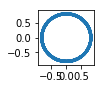

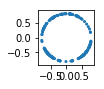

num of good points:4605
num of bad points:580


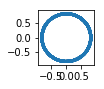

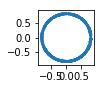

num of good points:10665
num of bad points:267


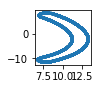

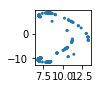

num of good points:12794
num of bad points:1500


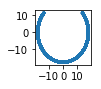

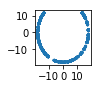

num of good points:3630
num of bad points:284


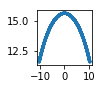

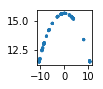

num of good points:1465
num of bad points:118


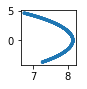

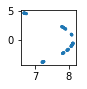

num of good points:2955
num of bad points:244


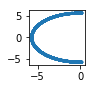

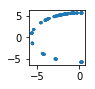

num of good points:346
num of bad points:43


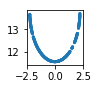

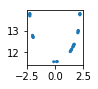

num of good points:344
num of bad points:45


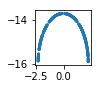

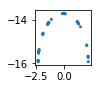

num of good points:19818
num of bad points:652


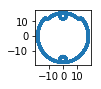

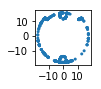

In [4]:
#Do a bunch of probably very redundant stuff because I don't know np or pd, but point being, get the filedata
#in using handy pd features, make it np, stick 1 on the end of "a" points (OK), stack "a" and "b" then remove
#duplicates (sort of like "preclean" - "cleaned" = "unclean"), then stick 0 on the end of "c" points (NG). Put
#all of it into memory as "d" (because it's 2018, OK?).
plt.rcParams['figure.figsize'] = [1, 1]
d = []
#for i in range(int(len(filelist)/2)) :
for i in range(10) :
    apoints = np.array(pd.read_table(zipis.open(pairs[i][0]), sep = '\s+', header = None, skiprows = 6, usecols = [1,2,3,4,5,6]))
    bpoints = np.array(pd.read_table(zipis.open(pairs[i][1]), sep = '\s+', header = None, skiprows = 6, usecols = [1,2,3,4,5,6]))  
    cpoints = pd.DataFrame(np.vstack((apoints,bpoints)))
    
    c = np.array(cpoints.drop_duplicates(subset = [0,1,2], keep = False, inplace = False))
    a = np.hstack((apoints, np.ones([apoints.shape[0],1])))
    c = np.hstack((c, np.zeros([c.shape[0],1])))

    #Some info if you want...
    if 2 == 2 :
        print('num of good points:' + str(a.shape[0]) + '\n' + 'num of bad points:' + str(c.shape[0]))
    
        #Some X,Y plots and data about the sets if you want...  
        plt.scatter(a[:,0],a[:,1], marker = '.', edgecolor = 'none')
        plt.show()
        plt.scatter(c[:,0],c[:,1], marker = '.', edgecolor = 'none')
        plt.show()
    
    d = d + [[a,c]]

In [5]:
#Some info to remember how this works...

#good/bad point sets and shape of one set
print(len(d))
#good and bad point set
print(len(d[0][0]))
print(len(d[0][1]))
#individual good and bad point
print(d[0][0][0])
print(d[0][1][0])
#xyz only
print(d[0][0][0][:3])

10
2514
233
[ 0.38147 -0.71481 -0.50228  0.45298 -0.89152  0.00131  1.     ]
[ 0.65547 -0.47316 -0.50122  0.86346 -0.50441  0.       0.     ]
[ 0.38147 -0.71481 -0.50228]


In [41]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import Model
import keras
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import neighbors
import random
from pyntcloud import PyntCloud

In [42]:
neighbors.KDTree.valid_metrics

['euclidean',
 'l2',
 'minkowski',
 'p',
 'manhattan',
 'cityblock',
 'l1',
 'chebyshev',
 'infinity']

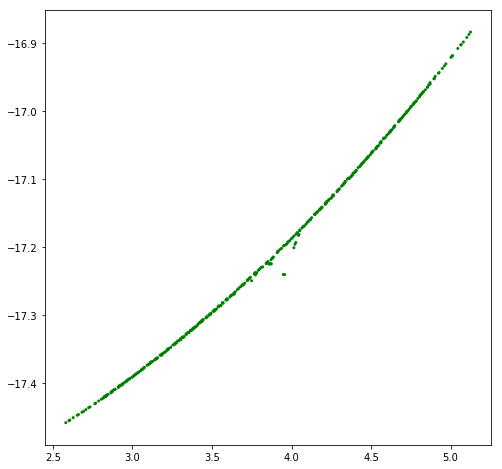

This chunk has bad points


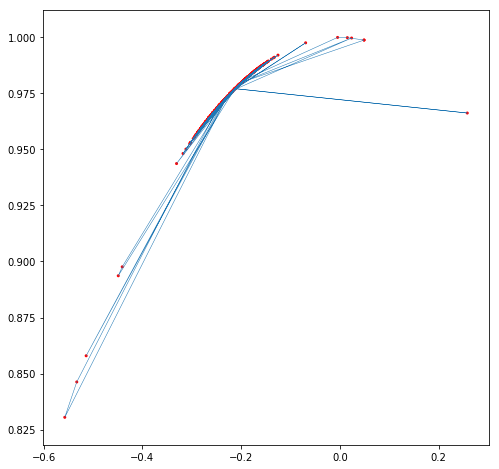

In [171]:
#stack a set of good and bad points, then make tree from nearest neighbors using only XYZ
wat = np.vstack([d[9][0],d[9][1]])
tree = neighbors.KDTree(wat[:,:3])
plt.rcParams['figure.figsize'] = [8, 8]
#plt.scatter(d[1][0][:,0],d[1][0][:,1])
#plt.show()
#plt.scatter(d[1][1][:,0],d[1][1][:,1])
#plt.show()

#make two np arrays split from prev. for e (group of) points, and f T/F contains bad points
e = np.array([])
e = e.reshape(0,6)
#subsample the larger point cloud randomly by picking one point index from all points
for i in range(1) :
    a = random.randrange(len(wat))
    b = wat[a,:3]
    b = b.reshape(1,-1)

    ###get chunk of nearest neighbors based on small random percent of total points
    c = 0.02
    #while c > 0.1 or c < 0.05 :
        #c = random.random()
        #print(c)
    ind = tree.query(b, k=(int(len(wat) * c)))[1]
    
    #print(ind)
    #print(d[0][0][ind])
    #e = np.vstack([e,wat[ind][0,:,:6]])
    
    ###sum up the T/Fs for all points in the chunk, and if not equal to total num of points, then has bad points
    watsum = sum(wat[ind][0,:,6])
    e = [wat[ind][0,:,:6]]
    plt.scatter(e[0][:,0],e[0][:,1], marker = '.', c = 'g', edgecolors = 'none')
    plt.show()
    
    if watsum == int(len(wat) * c) :
        f = np.array([1])
        print('This chunk has no bad points')
    else :
        f = np.array([0])
        print('This chunk has bad points')

    pbbt = PyntCloud(pd.DataFrame(e[0][:,:3], columns = ['x','y','z']))
    #pbbt.plot()
    
    sw = e[0][:,:2].min(0)
    #print('sw : ' + str(sw))
    ne = e[0][:,:2].max(0)
    #print('ne : ' + str(ne))
    nw = [sw[0],ne[1]]
    #print('nw : ' + str(nw))
    se = [ne[0],sw[1]]
    #print('se : ' + str(se))
    quad = np.array([[sw[0],sw[1]], [ne[0],ne[1]], [nw[0],nw[1]], [se[0],se[1]]])
    
    fullsub = e[0][:,:2]#np.vstack([e[0][:,:2],quad])
    #plt.scatter(fullsub[:,0],fullsub[:,1])
    #plt.show
    
    subtree = neighbors.KDTree(fullsub, leaf_size = 200, metric = 'minkowski', p = 4)
    tick = 0
    oldval = 0.0
    for j in range(4) :
        checkdist = subtree.query([quad[j]], k = (fullsub.shape[0]))[0][0]
        val = checkdist[0]
        #print(j,val,oldval)
        if val < oldval :
            tick += 1
            oldval = val
        if j == 0 :
            oldval = val
    
    subind = subtree.query([quad[tick]], k = (fullsub.shape[0]))[1][0]
    #print(subind)
    sube = [e[0][subind,:6]]
    plt.scatter(sube[0][:,3],sube[0][:,4], marker = '.', c = 'r', edgecolors = 'none')
    plt.plot(sube[0][:,3],sube[0][:,4], linewidth = 0.5)
    #plt.xlim(-1.01,1.01)
    #plt.ylim(-1.01,1.01)
    #plt.xscale('symlog')
    #plt.yscale('symlog')
    plt.show()
    testing = np.array(range(len(sube[0]))).reshape([-1,1])/1000
    testing = np.hstack([sube[0][:,3:5],testing])
    pbbtvec = PyntCloud(pd.DataFrame(testing, columns = ['x','y','z']))
    #pbbtvec.plot()
    
    ###feed each set into trainer
    #model.train_on_batch(e,f)
    
    
    

In [172]:
pbbtvoxvec = pbbtvec.add_structure('voxelgrid',n_x=64,n_y=64,n_z=64,regular_bounding_box = True)
voxgridvec = pbbtvec.structures[pbbtvoxvec]
voxgridvec.plot(d = 3, mode = 'density', cmap = 'plasma')

In [177]:
pbbtvox = pbbt.add_structure('voxelgrid',n_x=64,n_y=64,n_z=64,regular_bounding_box = True)
voxgrid = pbbt.structures[pbbtvox]
voxgrid.plot(d = 3, mode = 'density', cmap = 'plasma')

In [100]:
#model = Sequential()
#model.add(Dense(units=64, activation='relu', input_dim=1))
#model.add(Dense(units=1, activation='softmax'))
#model.compile(loss='categorical_crossentropy',
#              optimizer='sgd',
#              metrics=['accuracy'])
#pbbt = PyntCloud(pd.DataFrame(np.vstack([d[1][0][:,:3],d[1][1][:,:3]]), columns = ['x','y','z']))
#pbbt.plot()
#pbbtvox = pbbt.add_structure('voxelgrid',n_x=64,n_y=64,n_z=64)
#voxgrid = pbbt.structures[pbbtvox]
#voxgrid.plot(d = 3, mode = 'density', cmap = 'hsv')


#pbbtvec = PyntCloud(pd.DataFrame(np.vstack([d[1][0][:,3:6],d[1][1][:,3:6]]), columns = ['x','y','z']))
#pbbtvec.plot()
#pbbtvoxvec = pbbtvec.add_structure('voxelgrid',n_x=64,n_y=64,n_z=64)
#voxgridvec = pbbtvec.structures[pbbtvoxvec]
#voxgridvec.plot(d = 3, mode = 'density', cmap = 'hsv')
